<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Computer-Vision-Projects/blob/main/Image_classification_on_the_CIFAR_100_dataset_with_Vision_Transformer_(ViT)_from_Scratch_(Keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification on the CIFAR-100 dataset with Vision Transformer (ViT) using Keras

**Author:** [Ashaduzzaman Piash](https://github.com/ashaduzzaman-sarker/)
<br>
**Date Created:** 2024/06/16
<br>
**References:** [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](
https://doi.org/10.48550/arXiv.2010.11929
)

## Introduction

This example implements the Vision Transformer (ViT) model by Alexey Dosovitskiy et al. for image classification, and demonstrates it on the CIFAR-100 dataset. The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.

## Setup

In [1]:
!pip install --upgrade keras

In [2]:
import os

os.environ['KERAS_BACKEND'] = 'jax' # @param ['tensorflow', 'jax', 'torch']

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

## Prepare the data

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f'x_train shape: {x_train.shape} - y_train shape{y_train.shape}')
print(f'x_test shape: {x_test.shape} - y_test shape{y_test.shape}')

x_train shape: (50000, 32, 32, 3) - y_train shape(50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape(10000, 1)


## Configure the hyperparameters

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10 # num_epochs=100. 10 is a test value
image_size = 72 # input images
patch_size = 6 # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
] # size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
] # Size of the dense layers of the final classsifier


# Use data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name='data_augmentation',
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement multilayer perceptron (MLP)

In [6]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=keras.activations.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

## Implement patch creation as a layer

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

  # Input images and output patches
    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]

        # Calculate the number of patches along height and width
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        # Extract patches
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)

        # Reshape the patches to the desired shape
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )

        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

### Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patched per image: 144
Elements per patch: 108


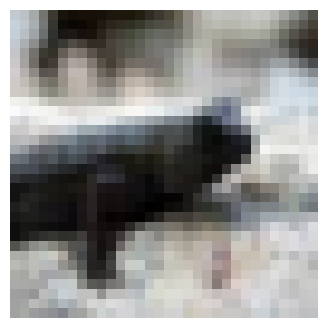

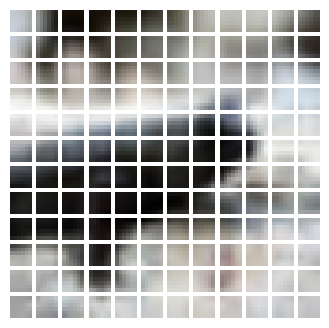

In [8]:
# Display a random image from x_train
plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

# Resize the image
resized_image = ops.image.resize(
    ops.convert_to_tensor([image]),
    size=(image_size, image_size)
)

# Extract patches
patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patched per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

# Display patches
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i+1)
  patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(ops.convert_to_numpy(patch_img).astype('uint8'))
  plt.axis('off')

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a vector of size `projection_dim`. In addition, it adds a learnable position embedding to the projected vector.

In [9]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches
    # Dense layer to project the patch into a specified dimension
    self.projection = layers.Dense(units=projection_dim)
    # Embedding layer to generate positional encodings
    self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )

  def call(self, patch):
    # Generate position indices for the patches
    positions = ops.expand_dims(
        ops.arange(start=0, stop=self.num_patches, step=1), axis=0
    )
    # Apply the dense layer to the patches (projection)
    projected_patches =self.projection(patch)
    # Add positional encodings to the projected patches
    encoded = projected_patches + self.position_embedding(positions)
    return encoded

  def get_config(self):
     # Ensure the layer can be serialized and deserialized
     config = super().get_config()
     config.update({'num_patches': self.num_patches})
     return config

## Build the ViT model

- **ViT Model Structure**:
  - Consists of multiple Transformer blocks.
  - Uses `layers.MultiHeadAttention` for self-attention on patch sequences.
  - Transformer blocks output a tensor with shape `[batch_size, num_patches, projection_dim]`.

- **Classifier Head**:
  - Processes the Transformer block output.
  - Applies softmax to produce final class probabilities.

- **Representation Technique**:
  - Unlike the original ViT paper, the learnable embedding is not prepended.
  - Instead, all outputs from the final Transformer block are reshaped using `layers.Flatten()`.
  - These reshaped outputs are used as input to the classifier head.

- **Alternative Aggregation**:
  - `layers.GlobalAveragePooling1D` can be used to aggregate Transformer block outputs.
  - This is particularly useful when dealing with a large number of patches and high projection dimensions.

In [10]:
def create_vit_classifier():
  inputs = keras.Input(shape=input_shape)
  # Augment Data
  augmented = data_augmentation(inputs)
  # Create Patches
  patches = Patches(patch_size)(augmented)
  # Encode patches
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  # Create multiple layers of the Transformer Block
  for _ in range(transformer_layers):
    # Layer normalization 1
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Create a multi_head attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    # Skip Connection 1
    x2 = layers.Add()([attention_output, encoded_patches])
    # Layer Normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    # MLP
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
    # Skip connection 2
    encoded_patches = layers.Add()([x3, x2])

  # Create a [batch_size, projection_dim] tensor
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)

  # Add MLP
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

  # Classify outputs
  logits = layers.Dense(num_classes)(features)

  # Create the Keras Model
  model = keras.Model(inputs=inputs, outputs=logits)

  return model

## Compile, train, and evaluate the model

In [11]:
# Function to run the training experiment
def run_experiment(model):
    # Define the optimizer with AdamW (Adam with weight decay)
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    # Compile the model with the optimizer, loss function, and metrics
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    # Filepath to save the best model weights
    checkpoint_filepath = '/tmp/checkpoint.weights.h5'

    # Callback to save the best model based on validation accuracy
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
    )

    # Train the model with the training data
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    # Load the best model weights
    model.load_weights(checkpoint_filepath)
    # Evaluate the model with the test data
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # Print test accuracy and top-5 accuracy
    print(f'Test Accuracy: {round(accuracy * 100, 2)}%')
    print(f'Test top 5 Accuracy: {round(top_5_accuracy * 100, 2)}%')

    return history

# Function that creates and returns the ViT model
vit_classifier = create_vit_classifier()
# Run the experiment with the ViT model
history = run_experiment(vit_classifier)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.0302 - loss: 4.8887 - top-5-accuracy: 0.1183 - val_accuracy: 0.1060 - val_loss: 3.8689 - val_top-5-accuracy: 0.3108
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.0875 - loss: 3.9959 - top-5-accuracy: 0.2746 - val_accuracy: 0.1534 - val_loss: 3.6174 - val_top-5-accuracy: 0.3994
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.1239 - loss: 3.7368 - top-5-accuracy: 0.3541 - val_accuracy: 0.2000 - val_loss: 3.3828 - val_top-5-accuracy: 0.4602
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.1568 - loss: 3.5186 - top-5-accuracy: 0.4156 - val_accuracy: 0.2238 - val_loss: 3.2364 - val_top-5-accuracy: 0.5034
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.1879 - loss: 3.3676 - top-5-accuracy: 0.4579 - val_accuracy: 0.2414 - val_loss: 3.1295 - val_top-5-accuracy: 0.5258
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.2078 - loss: 3.249

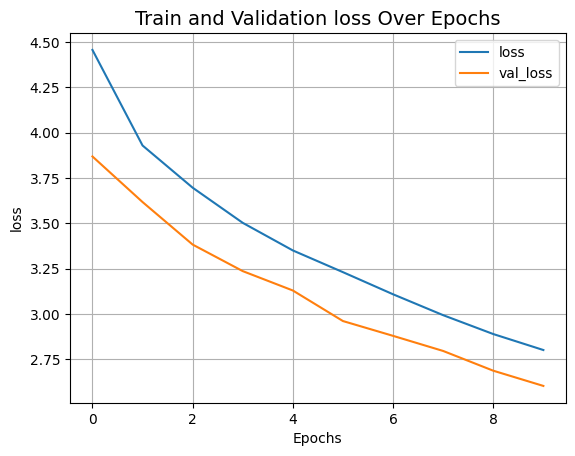

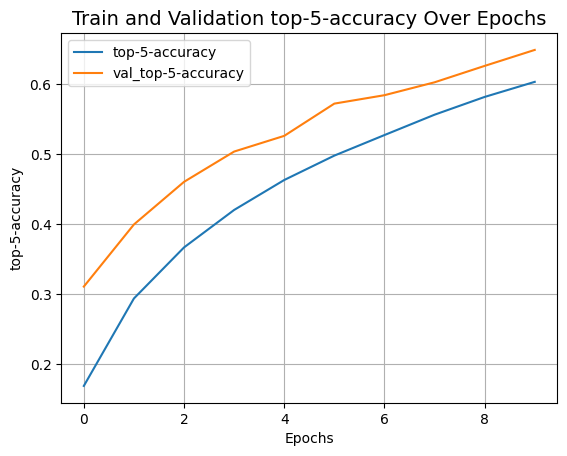

In [12]:
# Function to plot the training history
def plot_history(item):
  plt.plot(history.history[item], label=item)
  plt.plot(history.history['val_'+ item], label='val_' + item)
  plt.xlabel('Epochs')
  plt.ylabel(item)
  plt.title('Train and Validation {} Over Epochs'.format(item), fontsize=14)
  plt.legend()
  plt.grid()
  plt.show()

# Plot the training and validation loss over epochs
plot_history('loss')

# Plot the training and validation top-5 accuracy over epochs
plot_history('top-5-accuracy')

## Note
---
After 10 epochs, the ViT model achieves about `35.04% accuracy` and `64.82% top-5 accuracy` on the `CIFAR-100` test data. These results are not competitive compared to a ResNet50V2, which can achieve 67% accuracy on the same dataset.

The state-of-the-art results in the ViT paper were obtained by pre-training on the `JFT-300M dataset` and then fine-tuning on the target dataset. To improve the model without pre-training, consider training for more epochs, increasing the number of Transformer layers, resizing input images, changing the patch size, or increasing projection dimensions. Additionally, model quality depends on parameters like the learning rate schedule, optimizer, and weight decay. It's generally recommended to fine-tune a pre-trained ViT model on a large, high-resolution dataset.